In [1]:
import io
import socket
import struct
from PIL import Image
import matplotlib.pyplot as pl
import cv2
import numpy as np
import dlib

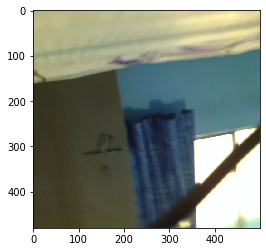

In [2]:
server_socket = socket.socket()
server_socket.bind(('192.168.0.102', 8000))  # ADD IP HERE
server_socket.listen(0)

# Accept a single connection and make a file-like object out of it
connectedSocket,addrr = server_socket.accept()
connection = connectedSocket.makefile('rb')

detector = dlib.get_frontal_face_detector()

try:
    img = None
    while True:
        # Read the length of the image as a 32-bit unsigned int. If the
        # length is zero, quit the loop
        image_len = struct.unpack('<L', connection.read(struct.calcsize('<L')))[0]
        if not image_len:
            break
        # Construct a stream to hold the image data and read the image
        # data from the connection
        image_stream = io.BytesIO()
        image_stream.write(connection.read(image_len))
        # Rewind the stream, open it as an image with PIL and do some
        # processing on it
        image_stream.seek(0)
        image = Image.open(image_stream)
        image = np.array(image)
        image = image[:, :, ::-1].copy() 
        if img is None:
            img = pl.imshow(image)
            connectedSocket.send(bytes("no face detected",'utf-8'))
        else:
            img.set_data(image)
            
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            faces = detector(gray)
            for face in faces:
                x1 = face.left()
                y1 = face.top()
                x2 = face.right()
                y2 = face.bottom()
                cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 3)
            if len(faces) != 0:
                connectedSocket.send(bytes("face detected",'utf-8'))
            else:
                connectedSocket.send(bytes("no face detected",'utf-8'))
            cv2.imshow("Feed from camera",image)
        key = cv2.waitKey(1)
        if key == 27:
            cv2.destroyAllWindows()
            break
        
finally:
    connection.close()
    server_socket.close()
    